# Gradient descent vs EM for dual line fitting

<a href="https://github.com/LouisFaure/Blog_notebooks/blob/main/gradLines/htad_vs_EM.ipynb"><img alt="Jupyter Notebook" src="https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&amp;logo=jupyter&amp;logoColor=white" style="margin-left:0;margin-top:0;margin-bottom:0;border-radius:5px; box-shadow:0 4px 16px 0 rgba(0, 0, 0, 0.1);"></a>

Here we will learn on how to use JAX to perform gradient descent to fit two line from datapoints that were generated by two separate processes. We will then show how to implement an EM approach to solve our system in a quicker way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
def generate_data(n_points=[50,50], par1 = [1,1], par2 = [1,1], noise= 50):
    x1=(np.arange(n_points[0])*par1[0]).astype(int)
    y1=(np.arange(n_points[0])*par1[1]).astype(int)
    x2=(np.arange(n_points[1])*par2[1]).astype(int)
    y2=(np.arange(n_points[1])*par2[0]).astype(int)

    x1=x1+np.random.randint(0,noise,len(x1))
    y1=y1+np.random.randint(0,noise,len(x1))
    
    x2=x2+np.random.randint(0,noise,len(x2))
    y2=y2+np.random.randint(0,noise,len(x2))

    xy=np.hstack([np.vstack([x1,y1]),np.vstack([x2,y2])]).T

    group=np.concatenate([np.ones(n_points[0]),np.zeros(n_points[0])])
    
    return x1,x2,y1,y2, xy, group

In [3]:
np.random.seed(42)
x1,x2,y1,y2, xy,group =generate_data(n_points=[50,50], par1 = [20,1], par2 = [10,10], noise= 100)

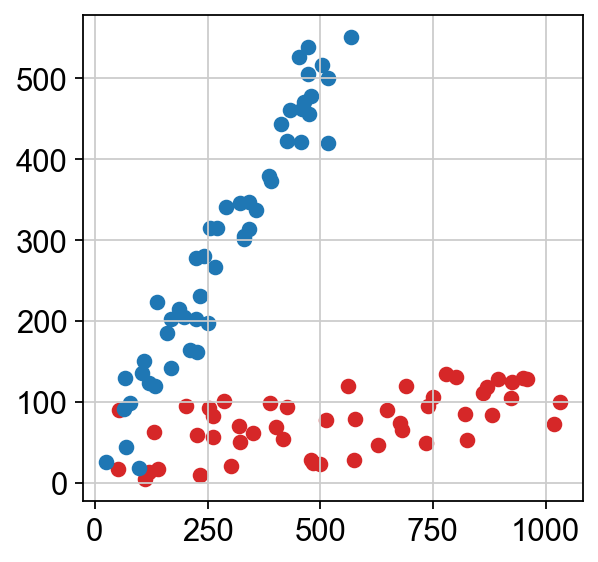

In [4]:
sc.set_figure_params()
plt.scatter(x1,y1,c="tab:red")
plt.scatter(x2,y2,c="tab:blue")

In [5]:
# Normalizing between 0 and 1 for better consistency between parameters
xy=xy/xy.max(axis=0)

## Introducing our model

With the additional information provided, I can rewrite your proposal as follows:

## Introducing our model

Let's define the residuals for each line as:

$$
\begin{aligned}
r_1 &= (l_1 - y)^2 \\
r_2 &= (l_2 - y)^2
\end{aligned}
$$

where $l_1$ and $l_2$ are the predictions of the two fitted lines, and $y$ represents the y-coordinates of the data points.

To fit these two sets of points, we will employ the following loss function:

$$
L = \sum_{i=1}^{N} \left[ \frac{r_{1,i} \times b_{1,i}}{\sum_{j=1}^{N} b_{1,j}} + \frac{r_{2,i} \times b_{2,i}}{\sum_{j=1}^{N} b_{2,j}} \right]
$$

This loss function models the assignment of each data point $i$ to one of the learned lines, through a weighted average of the residuals $r$ with the weights being a binary assignment $b$ of each point to its closest line:

$$
b_{1,i} =
\begin{cases}
    1, & \text{if } (r_{2,i} - r_{1,i}) > 0\\
    0, & \text{otherwise}
\end{cases}
$$

$$
b_{2,i} = 1 - b_{1,i}
$$


In [6]:
import jax
import jax.numpy as jnp

# Using jax.jit compiles to function for quicker runs
@jax.jit
def loss_fun(slopes):
    # Estimate lines using slope parameters
    l1 = jnp.dot(xy[:,0], slopes[0])
    l2 = jnp.dot(xy[:,0], slopes[1])

    # Calculate squared error
    r1 = (l1 - xy[:,1])**2
    r2 = (l2 - xy[:,1])**2

    # Binary assignment of points
    b1 = (r2-r1) > 0
    b2 = 1 - b1

    # Combine loss from both lines
    return ((r1*b1)/b1.sum()+(r2*b2)/b2.sum()).sum()

## Gradient Descent with JAX
### Initialisation of Slope Parameters

A proper strategy to get good initial parameters is to obtain the slope of a single linear fit using least-squares method, and assign that slope to both lines to be fitted:

In [7]:
s, _, _, _ = np.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [s.ravel()[0],s.ravel()[0]+0.001] # we add a little offset to help the start of training

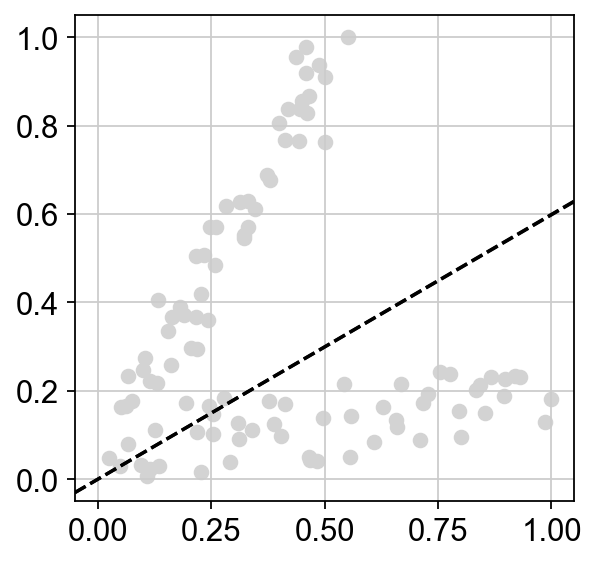

In [8]:
plt.scatter(xy[:,0],xy[:,1],c="lightgrey")
sl1 = slopes[0]
sl2 = slopes[1]
line1 = plt.axline([0, 0], slope=sl1, c="k", linestyle="--", zorder=99999)
line2 = plt.axline([0, 0], slope=sl2, c="k", linestyle="--", zorder=99999)

We have here two lines, nearly overlapping.

### Optimization Loop for Parameter Tuning 

In [9]:
import optax
optimizer=optax.adam(learning_rate=2e-2,b1=.9,b2=.999,eps=1e-8,eps_root=0.0)

Here are the default parameters: $\alpha_t$ represent the learning rate and $\beta_1$, $\beta_2$,
$\varepsilon$, $\bar{\varepsilon}$ represent the arguments
`b1`, `b2`, `eps` and `eps_root` respectively. The learning rate is
indexed by $t$ since the learning rate may also be provided by a
schedule function.


In [10]:
# initialize Adam with our slope parameters to track
opt_state = optimizer.init(slopes)
opt_state

(ScaleByAdamState(count=Array(0, dtype=int32), mu=[Array(0., dtype=float32), Array(0., dtype=float32)], nu=[Array(0., dtype=float32), Array(0., dtype=float32)]),
 EmptyState())

We can see here the current state $S$ of Adam optimizer, which is updated at each iteration.
`mu` and `nu` are initial estimates for the first and second moments $m_0$ and $v_0$. for each iteration these two moments are used to calculate:

$$
\begin{align*}
      m_t &\leftarrow \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t \\
      v_t &\leftarrow \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot {g_t}^2 \\
      \hat{m}_t &\leftarrow m_t / {(1-\beta_1^t)} \\
      \hat{v}_t &\leftarrow v_t / {(1-\beta_2^t)} \\
      u_t &\leftarrow -\alpha_t \cdot \hat{m}_t / \left({\sqrt{\hat{v}_t +
      \bar{\varepsilon}} + \varepsilon} \right)\\
      S_t &\leftarrow (m_t, v_t).
\end{align*}
$$

Let's move on with the training:

In [11]:
all_slopes=[]
all_slopes.append(slopes)
losses=[]
for step in range(200):
    # calculate current loss and related gradients
    loss, grads = jax.value_and_grad(loss_fun)(slopes)
    # takes in the current optimizer state and gradients and 
    # returns the updates that need to be applied to the parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    # applies the updates from the gradient transforms to the current parameters to return new ones
    slopes = optax.apply_updates(slopes, updates)
    # saving slope params and loss output for current iteration
    all_slopes.append(slopes)
    if ((step+1) % 20 == 0):
        print(f'Step {step+1}, Loss: {loss.item()}')
    losses.append(loss)

Step 20, Loss: 0.08323252201080322
Step 40, Loss: 0.03936617076396942
Step 60, Loss: 0.01695091649889946
Step 80, Loss: 0.009481729939579964
Step 100, Loss: 0.008024180307984352
Step 120, Loss: 0.007884365506470203
Step 140, Loss: 0.007882850244641304
Step 160, Loss: 0.007882487028837204
Step 180, Loss: 0.007882184349000454
Step 200, Loss: 0.007882163859903812


### Loss function

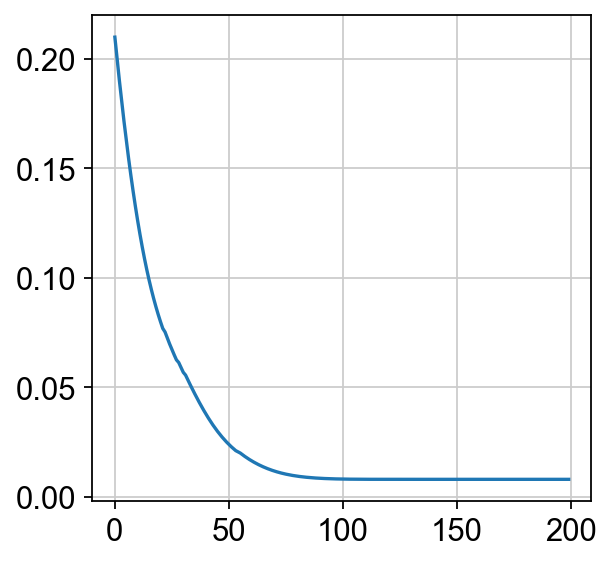

In [12]:
plt.plot(losses)

It seems we have converged after 200 iterations, let's look at the learned linear fits:

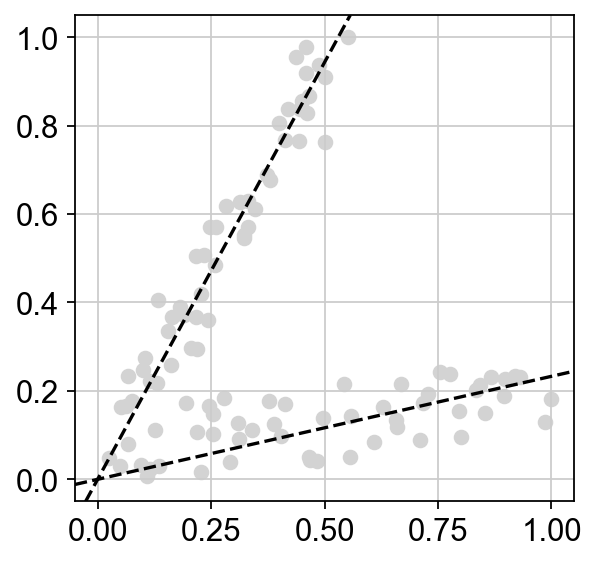

In [13]:
sc.set_figure_params()
plt.scatter(xy[:,0],xy[:,1],c="lightgrey")
plt.axline([0,0],slope=slopes[0],c="k",linestyle="--",zorder=99999)
plt.axline([0,0],slope=slopes[1],c="k",linestyle="--",zorder=99999)

The model works well, we captured both processes!

### Visualising the learning of parameters

It is quite fun to look the actual updates of the slope parameters as the gradient descent occurs, here is an animation showing also as a color the probability assignment of each point to one line or the other.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import matplotlib
from matplotlib.colors import Normalize

def generate_gif(xy, all_slopes, filename):
    # Set up the initial plot
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)

    # Initialize colormap and normalization
    cmap = matplotlib.colormaps["bwr"]
    norm = Normalize(vmin=0, vmax=1)

    # Initial scatter plot
    sc = ax.scatter(xy[:, 0], xy[:, 1],color="lightgrey",linewidth=.5,s=50)

    # Initial axlines
    sl1 = all_slopes[0][0]
    sl2 = all_slopes[0][1]
    line1, = ax.plot([], [], 'k--', zorder=99999)
    line2, = ax.plot([], [], 'k--', zorder=99999)

    # Update function
    def update(frame):
        # Remove previous lines
        line1.set_data([], [])
        line2.set_data([], [])

        # Add new lines with updated slopes
        sl1 = all_slopes[frame][0]
        sl2 = all_slopes[frame][1]
        x1 = np.array([-10, 10])
        y1 = sl1 * x1
        x2 = np.array([-10, 10])
        y2 = sl2 * x2
        line1.set_data(x1, y1)
        line2.set_data(x2, y2)
        return sc, line1, line2

    # Create the animation
    frames = np.concatenate([np.zeros(30,dtype=int),np.arange(len(all_slopes))])
    ani = animation.FuncAnimation(fig, update,frames=frames,blit=True, repeat=True)

    # To save the animation using Pillow as a gif
    writer = animation.PillowWriter(fps=30,
                                     metadata=dict(artist='Me'),
                                     bitrate=1800)
    ani.save(filename, writer=writer)

    # plt.show()
    plt.close()


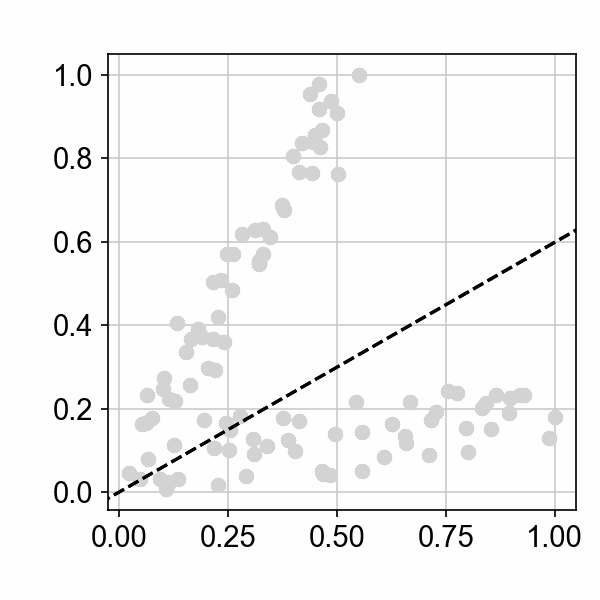

In [15]:
from IPython.display import Image
generate_gif(xy, all_slopes,filename='optim1.gif')
Image(open('optim1.gif','rb').read())

### Trying a higher learning rate

Let's increase the learning rate by one order of magnitude:

In [16]:
optimizer=optax.adam(1e-1)
s, _, _, _ = np.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [s.ravel()[0],s.ravel()[0]+0.001]

opt_state = optimizer.init(slopes)
all_slopes=[]
all_slopes.append(slopes)
losses=[]
for step in range(200):
    loss, grads = jax.value_and_grad(loss_fun)(slopes)
    updates, opt_state = optimizer.update(grads, opt_state)
    slopes = optax.apply_updates(slopes, updates)
    all_slopes.append(slopes)
    if ((step+1) % 20 == 0):
        print(f'Step {step+1}, Loss: {loss.item()}')
    losses.append(loss)

Step 20, Loss: 0.01561565138399601
Step 40, Loss: 0.008163165301084518
Step 60, Loss: 0.007922415621578693
Step 80, Loss: 0.007900070399045944
Step 100, Loss: 0.007886435836553574
Step 120, Loss: 0.00788265559822321
Step 140, Loss: 0.007882176898419857
Step 160, Loss: 0.00788217131048441
Step 180, Loss: 0.007882164791226387
Step 200, Loss: 0.007882162928581238


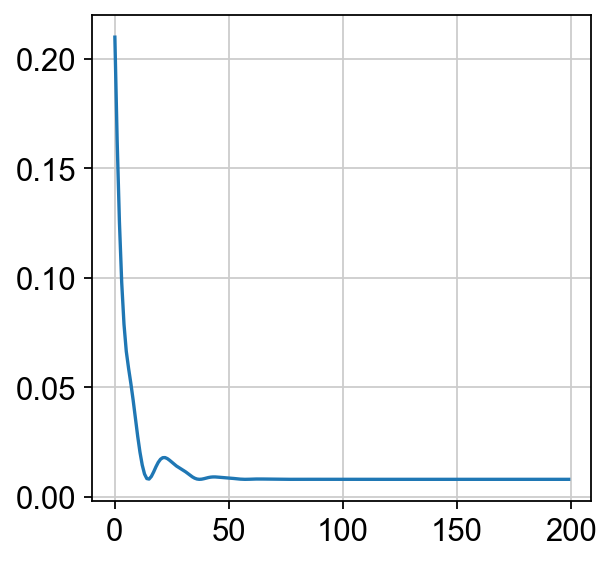

In [17]:
plt.plot(losses)

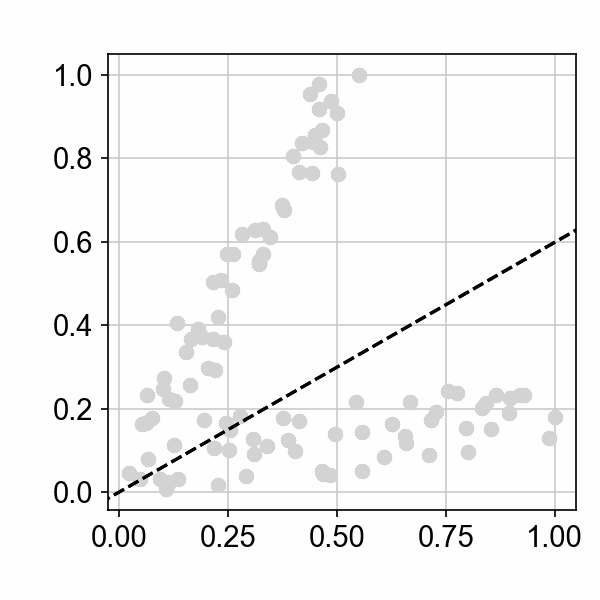

In [18]:
generate_gif(xy, all_slopes, filename='optim2.gif')
Image(open('optim2.gif','rb').read())

Here is a good example of the (spring-like!) flexibility of Adam optimizer: The large learning rate lead to an overshoot of the slope estimation, which is progressively dampened as the train progress, we even reach the global minima more rapidely!

### Estimating the performance of our model

Let's have a look at how good our model is in recovering the two initial groups of points:

In [19]:
def get_assignment(xy, slopes):
    l1 = np.dot(xy[:, 0], slopes[0])
    l2 = np.dot(xy[:, 0], slopes[1])
    r1 = (l1 - xy[:, 1])**2
    r2 = (l2 - xy[:, 1])**2
    f1 = (r2-r1) > 0
    return f1

f=get_assignment(xy,slopes)

In [20]:
from sklearn.metrics import accuracy_score
print(f"accuracy score: {accuracy_score(group,f):.4f}")

accuracy score: 0.9800


We are doing a very good job at recovering the two underlying processes!

## 100X speed improvement with EM-inspired approach!

While gradient descent can be attractive and easy to implement, it is important to note that other approaches mught be faster, enters expectation-maximization! 

In this case, the "Expectation" step involves computing the binary assignments $b_{1,i}$ and $b_{2,i}$ for each data point $i$, based on the current estimates of the two lines $l_1$ and $l_2$. These assignments represent the  membership of each data point to one of the two lines, based on the residuals $r_1$ and $r_2$.

The "Maximization" step involves re-estimating the parameters of the two lines $l_1$ and $l_2$ by performing separate linear fits on the data points, weighted by the binary assignments $b_{1,i}$ and $b_{2,i}$ computed in the Expectation step.

By performing two separate linear fits in the Maximization step, instead of gradient descent on the overall loss function, we are essentially decoupling the parameter estimation for the two lines, which can lead to faster convergence in certain cases.

Our approach is similar in spirit to the classical EM algorithm for Gaussian Mixture Models (GMMs), where the Expectation step computes the soft assignments of data points to different Gaussian components, and the Maximization step re-estimates the means, covariances, and mixing weights of the Gaussian components based on these assignments. In our case, the mixture components are linear models instead of Gaussians, and the assignments are binary (hard) instead of soft probabilities, but the overall iterative strategy is analogous to the EM algorithm.

In [21]:
s, _, _, _ = jnp.linalg.lstsq(xy[:,0].reshape(-1,1), xy[:,1].reshape(-1,1),rcond=None)
slopes = [s.ravel()[0],s.ravel()[0]+0.001] # we add a little offset to help the start of training

losses = [loss_fun(slopes)]

In [22]:
all_slopes = [slopes]
fs=[]
for i in range(10):
    # get binary assignment of points
    f=get_assignment(xy,slopes)
    fs.append(f)
    # estimate slope parameters for both sets of points
    s1, _, _, _ = jnp.linalg.lstsq(xy[f,0].reshape(-1,1), xy[f,1].reshape(-1,1),rcond=None)
    s2, _, _, _ = jnp.linalg.lstsq(xy[~f,0].reshape(-1,1), xy[~f,1].reshape(-1,1),rcond=None)
    slopes = [s1.ravel()[0],s2.ravel()[0]]
    # compute loss
    loss = loss_fun(slopes)
    if np.abs(losses[-1]-loss)<1e-9:
        break
    losses.append(loss)
    all_slopes.append(slopes)

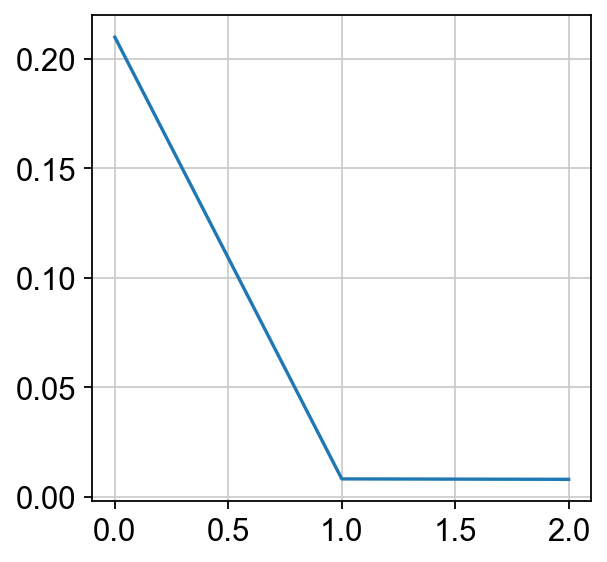

In [23]:
plt.plot(losses)

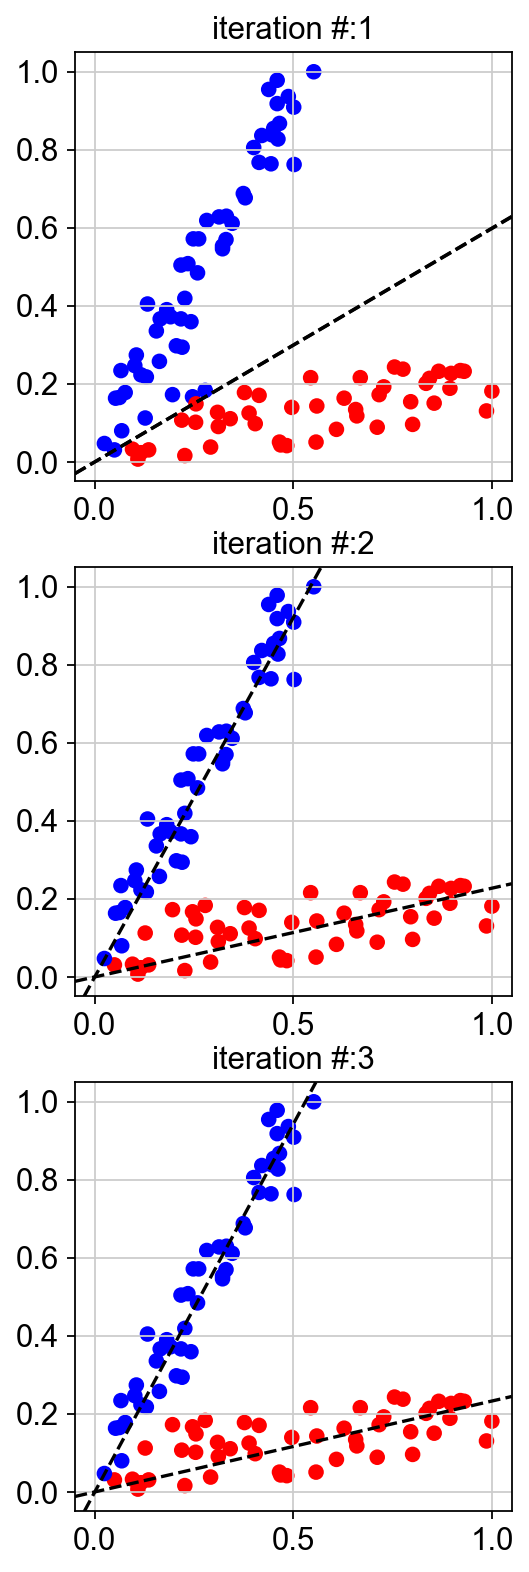

In [24]:
sc.set_figure_params()
fig, axs = plt.subplots(3,1,figsize=(3.5,12))
for i,(ax,sl,f) in enumerate(zip(axs,all_slopes,fs)):
    ax.scatter(xy[:,0],xy[:,1],c=f,cmap="bwr")
    ax.axline([0,0],slope=sl[0],c="k",linestyle="--",zorder=99999)
    ax.axline([0,0],slope=sl[1],c="k",linestyle="--",zorder=99999)
    ax.set_title(f"iteration #:{i+1}")

We reached the final result in only three iterations! This is much faster than gradient descent! The whole optimization loop took ~4ms instead of ~400ms for gradient descent.